# Actor-Critic 算法

教程链接：[Actor-Critic 算法](https://hrl.boyuai.com/chapter/2/actor-critic%E7%AE%97%E6%B3%95)

Actor-Critic 算法本质上是基于策略的算法，因为这一系列算法的目标都是优化一个带参数的策略，只是会额外学习价值函数，从而帮助策略函数更好地学习。Actor-Critic 是囊括一系列算法的整体架构，目前很多高效的前沿算法都属于 Actor-Critic 算法。

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class PolicyNet(nn.Module):
    """
    定义策略网络，与REINFORCE算法一样。其输入是某个状态，输出则是该状态下的动作概率分布
    """
    def __init__(self, state_dim:int, hidden_dim:int, action_dim:int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [3]:
class ValueNet(nn.Module):
    """
    定义价值网络，其输入是某个状态，输出则是状态的价值。
    """
    def __init__(self, state_dim:int, hidden_dim:int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [6]:
class ActorCritic(rl_utils.BasePolicy):
    """
    定义ActorCritic算法
    """
    def __init__(self, 
            state_dim:int, hidden_dim:int, action_dim:int, 
            actor_lr:float, critic_lr:float, gamma:float, device:torch.device
        ):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)                                     
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)  

        self.gamma = gamma
        self.device = device

    def take_action(self, state:np.ndarray) -> int:
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict:dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        # 时序差分误差
        td_delta = td_target - self.critic(states)  
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        # 均方误差损失函数
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数

In [8]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 100/100 [02:27<00:00,  1.47s/it, episode=1000, return=200.000]


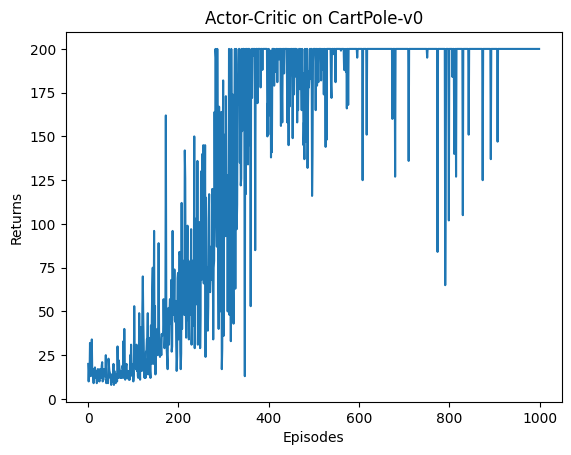

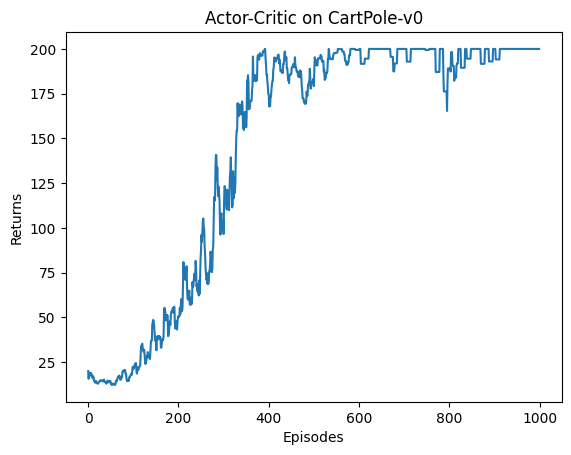

In [9]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

根据实验结果我们可以发现，Actor-Critic 算法很快便能收敛到最优策略，并且训练过程非常稳定，抖动情况相比 REINFORCE 算法有了明显的改进，这说明价值函数的引入减小了方差。